# Q learning game

In [48]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [49]:
df = pd.read_csv('grid.txt',header=None,sep=' ')
grille = np.array(df.drop(15, axis=1))
grille

array([[ 1, 19,  9,  9,  8, 18, 13,  0, 13,  2, 18, 18, 17,  9,  0],
       [16,  1, 10,  8,  6, 16, 16, 18, 14, 18, 15, 17, 20, 15, 17],
       [ 5,  3, 19, 14,  1,  0,  3,  8, 15, 12,  2, 15, 15, 15,  2],
       [ 8, 20,  7, 20,  6, 14, 12,  4,  3,  7, 19, 11, 15,  8,  8],
       [15,  8,  8, 14, 12, 16,  8,  2, 10, 16, 17,  1, 12,  0, 17],
       [ 0, 12, 18, 13,  1,  3,  2, 17, 10,  7,  4, 15, 19,  8, 13],
       [ 2, 13, 20,  1, 19,  4,  1,  1,  0, 14,  4,  3, 12,  2,  8],
       [11,  3,  2, 20,  9, 15,  1, 18, 14, 13,  2,  3, 17, 13, 20],
       [16,  5,  9,  9,  5, 17, 16,  4, 18,  9,  1,  3,  7,  6, 13],
       [17, 17,  1,  6, 10,  3, 15, 13,  7,  1,  9, 10,  9, 18, 13],
       [ 3, 20, 19,  3, 15,  4, 17,  0, 18, 14, 18,  8,  3, 16,  2],
       [ 7,  3,  5, 14,  0,  8,  6,  3,  4, 13,  3, 10, 15, 13, 14],
       [16,  2, 16, 15,  9,  1, 13,  7, 14,  0,  4,  1,  3,  9,  2],
       [ 3,  3,  4, 17, 12, 12, 20,  5, 19, 14,  6,  4, 14,  5, 11],
       [12,  4,  1, 15,  5, 10,  0

In [50]:
grille.shape

(15, 15)

In [51]:
dico_states = {}
num_state = 0
for row in range(grille.shape[0]):
    for col in range(grille.shape[1]):
        dico_states[(row,col)] = num_state
        num_state += 1

In [52]:
def move(grille, coord, direction):
    '''
    if direction == 0: # north
        if coord[0] == 0:
            return coord
        else:
            return (coord[0]-1,coord[1])
    '''
    if direction == 2: # south
        if coord[0] == grille.shape[0]-1:
            return coord
        else:
            return (coord[0]+1,coord[1])
    if direction == 1: # east
        if coord[1] == grille.shape[1]-1:
            return coord
        else:
            return (coord[0],coord[1]+1)
    '''
    if direction == 3: # west
        if coord[1] == 0:
            return coord
        else:
            return (coord[0],coord[1]-1)
    '''
    return coord

def training_step(grille, coord, action, memory):
    new_coord = move(grille, coord, action)
    reward = 0
    if coord == new_coord or new_coord in memory: # Prevent agent to stay on same cell or return on previous cell
        reward = -100
    else:
        reward = -grille[new_coord[0]][new_coord[1]] # penalty for number in each case
    done = False
    if new_coord == (grille.shape[0]-1, grille.shape[1]-1):
        done == True
    return new_coord, reward, done

## Test game

In [53]:
coord = (0,0)
state = dico_states[coord]
reward = -grille[0][0]
done = False

keep_score, keep_coord, keep_state, keep_action = [],[],[],[]
keep_mov = 0

keep_score.append(reward)
keep_state.append(dico_states[coord])

all_actions = [1,1,2,2,1,1,2,2]

memory = [coord]
for action in all_actions:
    keep_action.append(action)

    coord, reward, done = training_step(grille, coord, action, memory)
    memory.append(coord)

    keep_score.append(reward)
    keep_state.append(dico_states[coord])
    keep_mov += 1

print(keep_action)
print()
print([str(memory[i])+': '+str(dico_states[memory[i]]) for i in range(len(memory))])
print()
print(keep_score)
print(sum(keep_score))

[1, 1, 2, 2, 1, 1, 2, 2]

['(0, 0): 0', '(0, 1): 1', '(0, 2): 2', '(1, 2): 17', '(2, 2): 32', '(2, 3): 33', '(2, 4): 34', '(3, 4): 49', '(4, 4): 64']

[-1, -19, -9, -10, -19, -14, -1, -6, -12]
-91


## Q learning

In [54]:
action_size = 4 # n,s,e,w
state_size = len(dico_states)
print("Number of actions: {}".format(action_size))
print("Number of states: {}".format(state_size))

# Initialize Q table
qtable = np.zeros((state_size, action_size))

total_episodes = 10000
max_steps = 99

alpha = 0.7 # learning rate
gamma = 0.9 # discount rate

epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01 # used to reduce epsilon

Number of actions: 4
Number of states: 225


training episode 10000


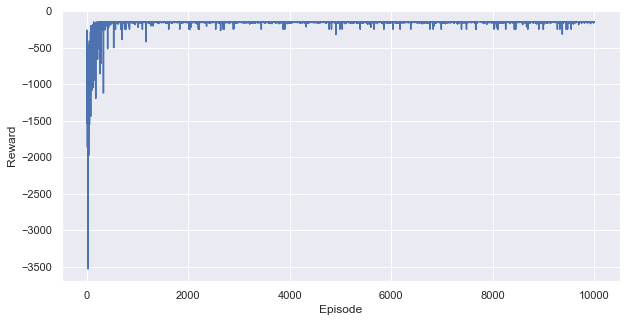

In [55]:
rewards = []

for episode in range(total_episodes):
    # Reset environment at each new episode
    coord = (0,0)
    state = dico_states[coord]
    reward = -grille[0][0]
    done = False
    memory = [coord]

    unit_step = 0
    total_rewards = 0 # just to save progress of learning
    
    for unit_step in range(max_steps):
        
        # Select action according to exploration/exploitation trade-off
        if random.uniform(0,1) > epsilon:
            # exploitation : select action with biggest Q value for this state
            action = np.argmax(qtable[state, :])
        else:
            # exploration: random action choice
            #action = random.randint(0,3)
            action = random.randint(1,2) #only east and south allowed
        
        # Do action (a) and observe the outcome state (s') and reward (R)
        coord, reward, done = training_step(grille, coord, action, memory)
        memory.append(coord)
        new_state = dico_states[coord]
        
        # Increment total reward
        total_rewards += reward
    
        '''
        Update q value for the state based on the Bellman equation
        Q(s,a) = Q(s,a) + alpha*[R(s,a) + gamma*max(Q(s',a') - Q(s,a))]
        '''
        qtable[state, action] = qtable[state, action] + \
            alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
        
        # Increment state
        state = new_state
        
        if coord == (14,14):
            break
    
    # Increment episode
    episode += 1
    
    # Save reward of each step
    rewards.append(total_rewards) 
    
    # Reduce epsilon to reduce the number of exploration for next episodes
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    
    # Display progree each batch of episodes
    if episode%total_episodes/100 == 0:
        print('training episode',episode)
        
# Plot learning graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward');

In [56]:
qtable[:20]

array([[-70.        , -59.70997158, -56.70997158, -70.        ],
       [-70.        , -45.45017694, -45.23330176, -70.        ],
       [-70.        , -40.83821598, -42.48446004, -70.        ],
       [-70.        , -37.72928704, -41.0900157 , -70.        ],
       [-70.        , -37.00724075, -36.52395598, -70.        ],
       [-70.        , -23.80285976, -40.08547467, -70.        ],
       [-70.        , -13.01842364, -13.03897   , -70.        ],
       [-70.        , -19.74468307, -27.39205279, -70.        ],
       [-70.        , -14.69594   , -24.65582   , -70.        ],
       [-70.        , -17.514     , -25.8070365 , -70.        ],
       [-70.        , -12.6       , -33.163809  , -70.        ],
       [-70.        ,   0.        , -11.9       ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-70.        , -45

In [59]:
# Test agent
coord = (0,0)
state = dico_states[coord]
reward = -grille[0][0]
done = False
memory=[coord]

keep_score, keep_coord, keep_state, keep_action = [],[],[],[]
keep_mov = 0

for step in range(max_steps):

    keep_score.append(reward)
    keep_coord.append(coord)
    keep_state.append(dico_states[coord])
    keep_mov += 1

    action = np.argmax(qtable[state, :])
    keep_action.append(action)

    coord, reward, done = training_step(grille, coord, action, memory)
    memory.append(coord)
    new_state = dico_states[coord]
    total_rewards += reward
    
    if coord == (14,14):
        break

    state = new_state

print(keep_action)
print()
print([str(keep_coord[i])+' : '+str(dico_states[keep_coord[i]])for i in range(len(keep_coord))])
print()
print(keep_score)
print('total score:',sum(keep_score)-5)
print('max move:',len(keep_action))

[2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1]

['(0, 0) : 0', '(1, 0) : 15', '(1, 1) : 16', '(1, 2) : 17', '(1, 3) : 18', '(1, 4) : 19', '(2, 4) : 34', '(2, 5) : 35', '(2, 6) : 36', '(3, 6) : 51', '(4, 6) : 66', '(5, 6) : 81', '(6, 6) : 96', '(6, 7) : 97', '(6, 8) : 98', '(6, 9) : 99', '(6, 10) : 100', '(7, 10) : 115', '(8, 10) : 130', '(8, 11) : 131', '(9, 11) : 146', '(10, 11) : 161', '(11, 11) : 176', '(12, 11) : 191', '(12, 12) : 192', '(12, 13) : 193', '(13, 13) : 208', '(14, 13) : 223']

[-1, -16, -1, -10, -8, -6, -1, 0, -3, -12, -8, -2, -1, -1, 0, -14, -4, -2, -1, -3, -10, -8, -10, -1, -3, -9, -5, -3]
total score: -148
max move: 28


In [70]:
df_path = pd.DataFrame(grille)
score = 0
mov = 0
for coordinate in memory:
    score += df_path.loc[coordinate[0], coordinate[1]]
    mov += 1
    df_path.loc[coordinate[0], coordinate[1]] = '-'+str(df_path.loc[coordinate[0], coordinate[1]])+'-'

print(score)
print(mov)
df_path

148
29


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1-,19,9,9,8,18,13,0,13,2,18,18,17,9,0
1,-16-,-1-,-10-,-8-,-6-,16,16,18,14,18,15,17,20,15,17
2,5,3,19,14,-1-,-0-,-3-,8,15,12,2,15,15,15,2
3,8,20,7,20,6,14,-12-,4,3,7,19,11,15,8,8
4,15,8,8,14,12,16,-8-,2,10,16,17,1,12,0,17
5,0,12,18,13,1,3,-2-,17,10,7,4,15,19,8,13
6,2,13,20,1,19,4,-1-,-1-,-0-,-14-,-4-,3,12,2,8
7,11,3,2,20,9,15,1,18,14,13,-2-,3,17,13,20
8,16,5,9,9,5,17,16,4,18,9,-1-,-3-,7,6,13
9,17,17,1,6,10,3,15,13,7,1,9,-10-,9,18,13
